In [109]:
import pandas as pd
import numpy as np
import spacy
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

In [105]:
columns = ['id','country','Label','Text']
df = pd.read_csv("twitter_training.csv", names=columns)
df.head(5)

,id,country,Label,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
display(df['Label'].value_counts())

Label
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [9]:
df.drop(['country' , 'id'] , axis=1 , inplace = True)

In [11]:
df.isnull().sum()

Label      0
Text     686
dtype: int64

In [13]:
df.dropna(inplace=True)

## **Data Cleaning**

**LowerCasing Text**

In [17]:
df['Text'] = df['Text'].str.lower()

df.head()

,Label,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


**Removing HTML tags**

In [20]:
def remove_html(text):

    clean_text = BeautifulSoup(text , 'html.parser')

    return clean_text.get_text()

In [22]:
df['Text'] = df['Text'].apply(remove_html)

display(df['Text'].head(2))

C:\Users\malawy\AppData\Local\Temp\ipykernel_10844\481714407.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text , 'html.parser')


0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
Name: Text, dtype: object

**Removing URLs**

In [24]:
def clean_url(text):
    
    return re.sub(r'http\S+|www\S+', '', text)

In [27]:
df['Text'] = df['Text'].apply(clean_url)

df.head()

,Label,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


**Removing Punctuation**

In [30]:
def remove_punctuation(text):
    
    return re.sub(r'[^\w\s]', '', text)

In [32]:
df['Text'] = df['Text'].apply(remove_punctuation)

df.head()

,Label,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you all
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


**Removing Stop Words**

In [35]:
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return text
        
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [37]:
df['Text'] = df['Text'].apply(remove_stopwords)

**Removing Emojis**

In [39]:
def remove_emojis(text):
    return emoji.demojize(text)

df['Text'] = df['Text'].apply(remove_emojis)

**Lemmatization**

In [42]:
def lemmatize_text(text):
    
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['Text_lemmatized'] = df['Text'].apply(lemmatize_text)

In [44]:
df.head()

,Label,Text,Text_lemmatized
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland 2 murder


In [46]:
df["Text_lemmatized"] = df["Text_lemmatized"].str.replace(r'\bgame\b', '', regex=True)

In [48]:
df['Label'] = df['Label'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [50]:
df['Label'].value_counts()

Label
2    30983
0    22358
1    20655
Name: count, dtype: int64

## **Data Splitting**

In [53]:
X = df['Text_lemmatized'] 
y = df['Label']

X_train1 , X_test , y_train1 , y_test = train_test_split(X,y , random_state = 42 , test_size = 0.2  , shuffle = True)
X_train , X_val , y_train , y_val = train_test_split(X_train1 , y_train1 , random_state = 42 , test_size = 0.15  , shuffle = True)

## **Tokenization**

In [56]:
tokenizer = Tokenizer(oov_token = 'nothing')
tokenizer.fit_on_texts(X_train)

**Conversion To Sequence**

In [59]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

**Padding**

In [62]:
max_len = max(len(tokens) for tokens in X_train_seq)

In [64]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [66]:
vocab_size = len(tokenizer.word_index) + 1

print(vocab_size)

30935


## **Model Building**

In [73]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128 , return_sequences = True , dropout = 0.2 , recurrent_dropout = 0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64 , dropout = 0.2 , recurrent_dropout = 0.2)),
    tf.keras.layers.Dense(64 , activation='relu'  , kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(3 , activation = 'softmax')

])

In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

**Compile Model**

In [78]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

**Model Trainig**

In [81]:
history = model.fit(
      X_train_padded,  
      y_train,  
      validation_data=(X_val_padded, y_val),
      batch_size=32,  
      epochs=30,  
      callbacks=[early_stopping , reduce_lr],
      verbose=1 
  )

Epoch 1/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 806s 502ms/step - accuracy: 0.6051 - loss: 0.8449 - val_accuracy: 0.7940 - val_loss: 0.5215 - learning_rate: 0.0010
Epoch 2/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 796s 506ms/step - accuracy: 0.8563 - loss: 0.3679 - val_accuracy: 0.8555 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 3/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 708s 450ms/step - accuracy: 0.9094 - loss: 0.2297 - val_accuracy: 0.8536 - val_loss: 0.3861 - learning_rate: 0.0010
Epoch 4/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 675s 429ms/step - accuracy: 0.9281 - loss: 0.1747 - val_accuracy: 0.8720 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 5/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 671s 426ms/step - accuracy: 0.9379 - loss: 0.1472 - val_accuracy: 0.8748 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 6/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 707s 450ms/step - accuracy: 0.9452 - loss: 0.1264 - val_accuracy: 0.8761 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 7/30
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/s

## **Model Summary**

In [84]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 99, 100)        │     3,093,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 99, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,502,399 (40.06 MB)

 Trainable params: 3,500,799 (13.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,001,600 (26.71 MB)

## **Evaluation**

In [87]:
# Get model predictions (probabilities)
y_probs = model.predict(X_test_padded)

# Converting probs into Binary values
y_pred = np.argmax(y_probs, axis=1)

463/463 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step


**Accuracy**

In [90]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

463/463 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.8669 - loss: 0.3720
Loss: 0.3676065504550934, Accuracy: 0.8694594502449036


**Confusion Matrix**

In [93]:
cfm = confusion_matrix(y_test , y_pred)

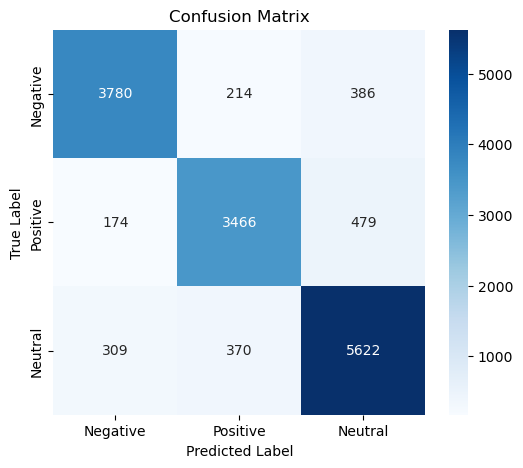

In [111]:
plt.figure(figsize=(6, 5))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative' , 'Positive' , 'Neutral'], yticklabels=['Negative' , 'Positive','Neutral'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Classification Report**

In [98]:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      4380
           1       0.86      0.84      0.85      4119
           2       0.87      0.89      0.88      6301

    accuracy                           0.87     14800
   macro avg       0.87      0.87      0.87     14800
weighted avg       0.87      0.87      0.87     14800



## **Save The Model**

In [101]:
model.save("twitter_sentiment_model.h5")